In [1]:
import baccoemu
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import scipy
import warnings

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import plot_utils
import plotter
import utils
import data_loader

%load_ext autoreload
%autoreload 2

2025-03-21 02:35:50.153167: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-21 02:35:50.263446: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-21 02:35:50.263492: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-21 02:35:50.277879: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-21 02:35:50.312879: I tensorflow/core/platform/cpu_feature_guar

In [2]:
%matplotlib inline
mpl.pyplot.style.use('default')
mpl.pyplot.close('all')

font, rcnew = plot_utils.matplotlib_default_config()
mpl.rc('font', **font)
mpl.pyplot.rcParams.update(rcnew)
mpl.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

In [3]:
data_mode = 'emuPk'
assert data_mode in ['emuPk', 'muchisimocksPk']

idxs_obs = [0]

In [4]:
#tag_flow = '_nsf'
tag_flow = ''

In [15]:
data_mode = 'emuPk'
#data_mode = 'muchisimocksPk'

# train params
tag_params = '_p5_n10000'
tag_biasparams = '_b1000_p0_n1'
#tag_biasparams = '_biaszen_p4_n10000'
n_rlzs_per_cosmo = 1
n_train = 10000

# test params
tag_params_test = '_quijote_p0_n1000'
tag_biasparams_test = '_b1000_p0_n1'
#tag_biasparams_test = '_biaszen_p4_n1000'
    
# this if-else is just so it's easier for me to switch between the two; may not need
if data_mode == 'emuPk':
    # train
    tag_errG = '_boxsize1000'
    tag_datagen = f'{tag_errG}_nrlzs{n_rlzs_per_cosmo}'
    # test
    tag_errG = '_boxsize1000'
    tag_noiseless = ''
    #tag_noiseless = '_noiseless' # if use noiseless, set evaluate_mean=False (?)
    tag_datagen_test = f'{tag_errG}_nrlzs{n_rlzs_per_cosmo}'
    kwargs_data_test = {'n_rlzs_per_cosmo': n_rlzs_per_cosmo,
                        'tag_errG': tag_errG,
                        'tag_datagen': tag_datagen,
                        'tag_noiseless': tag_noiseless}
elif data_mode == 'muchisimocksPk':
    # train
    tag_datagen = ''
    # test
    tag_noiseless = ''
    tag_datagen_test = ''
    kwargs_data_test = {'tag_datagen': tag_datagen}

# don't need train kwargs here bc not actually loading the data; just getting tag to reload model
tag_data_train = '_'+data_mode + tag_params + tag_biasparams + tag_datagen
tag_data_test = '_'+data_mode + tag_params_test + tag_biasparams_test + tag_datagen_test + tag_noiseless

In [16]:
tag_inf = f'{tag_data_train}_ntrain{n_train}{tag_flow}'
print(tag_inf)

_emuPk_p5_n10000_b1000_p0_n1_boxsize1000_nrlzs1_ntrain10000


In [17]:
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams)
params_df_test, param_dict_fixed_test, biasparams_df_test, biasparams_dict_fixed_test, random_ints_test, random_ints_bias_test = data_loader.load_params(tag_params_test, tag_biasparams_test)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary = [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]

In [18]:
# for when have a LH
if 'p0' in tag_params_test and 'p0' in tag_biasparams_test:
    theta_test = [param_dict_fixed_test[pname] for pname in cosmo_param_names_vary]
    theta_test.extend([biasparams_dict_fixed_test[pname] for pname in bias_param_names_vary])
    theta_test = np.repeat(theta_test, len(idxs_obs))
    theta_test = np.atleast_2d(theta_test)
else:
    theta_test, param_names = data_loader.param_dfs_to_theta(params_df_test, biasparams_df_test, n_rlzs_per_cosmo=n_rlzs_per_cosmo)
    assert param_names == param_names_vary, "param_names_vary and param_names should match! something wrong"

# Check SBI training

In [19]:
import pickle
dir_sbi = f'../results/results_sbi/sbi{tag_inf}'

fn_inference = f'{dir_sbi}/inference.p'
with open(fn_inference, "rb") as f:
    inference = pickle.load(f)

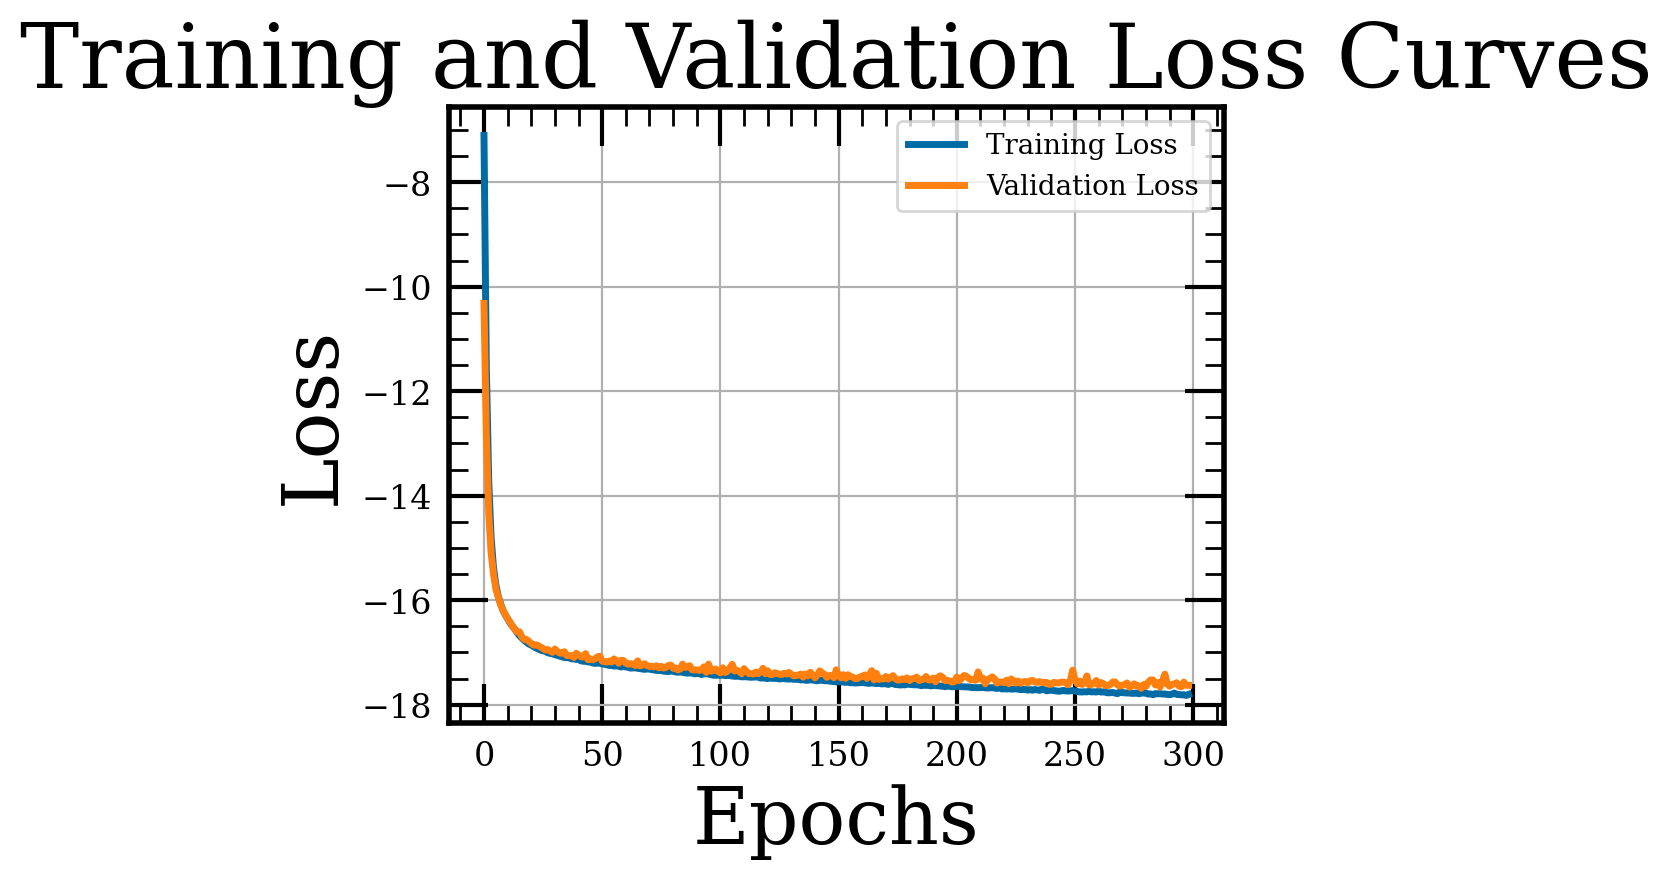

In [20]:
# Extract training and validation loss
training_loss = inference._summary["training_loss"]
validation_loss = inference._summary["validation_loss"]

# Plot the loss curves
plt.figure(figsize=(5, 4))
plt.plot(training_loss, label="Training Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend(fontsize=10)
#plt.ylim(-10.5, -10)
plt.grid(True)

[0.3175 0.834  0.6711 0.049  0.9624]
['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns']
fn_samples = ../results/results_sbi/sbi_emuPk_p5_n10000_b1000_p0_n1_boxsize1000_nrlzs1_ntrain10000/samples_test_emuPk_quijote_p0_n1000_b1000_p0_n1_boxsize1000_nrlzs1_mean_pred.npy
(10000, 1, 5)


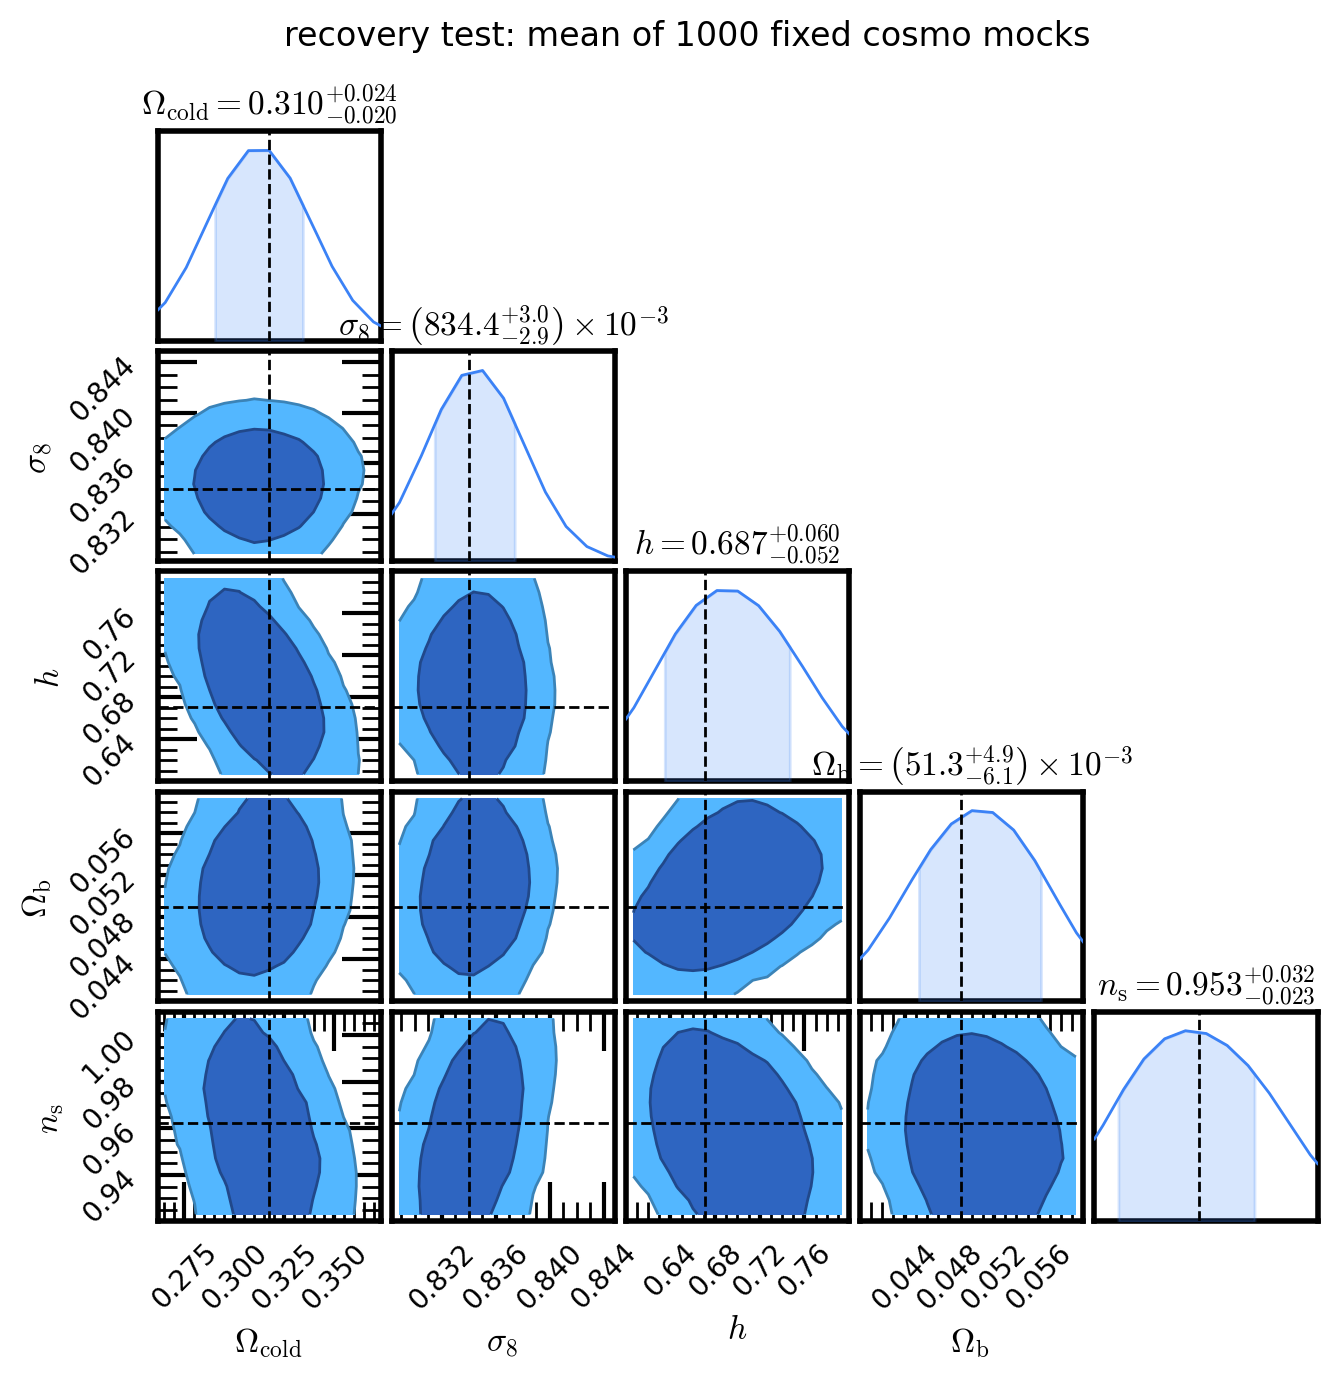

In [21]:
inf_methods = [
               #'dynesty',
               'sbi',
              ]
tags_inf = [
            #tag_inf,
            tag_inf,
            ]
tags_test = [
             #None,
             f'{tag_data_test}_mean',
            ]
labels_extra = [
                '',
                ]
title = 'recovery test: mean of 1000 fixed cosmo mocks'
#colors = [utils.color_dict_methods[meth] for meth in inf_methods]
colors = ['blue']
#colors = ['#63E0CF', 'cyan', 'blue', '#2E3CA2']
#colors[1] = 'purple'

param_names_vary = cosmo_param_names_vary

for idx_obs in [0]:
    theta_obs_true = theta_test[idx_obs]
    #
    # = theta_test
    print(theta_obs_true)
    print(param_names_vary)
    plotter.plot_contours_inf(param_names_vary, idx_obs, theta_obs_true, 
                            inf_methods, tags_inf, tags_test=tags_test,
                            colors=colors, labels_extra=labels_extra,
                            title=title)

In [26]:
inf_methods = [
               "sbi",
               #'sbi'
              ]
tags_inf = [
            f'_emuPk_p5_n10000_b1000_p0_n1_boxsize1000_nrlzs1_ntrain10000{tag_flow}',
            #f'_{data_mode}_p5_n10000_biaszen_p4_n10000_ntrain10000{tag_flow}',
            ]
tags_test = [
             f'{tag_data_test}',
             #f'{tag_data_test}'
            ]
labels_extra = [
                '(b=[1,0,0,0])',
                #'(free bias parameters)',
                ]
#colors = [ut
# ils.color_dict_methods[meth] for meth in inf_methods]
colors = ['blue', 'cyan']

[0.3175 0.834  0.6711 0.049  0.9624]
['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns']
fn_samples = ../results/results_sbi/sbi_emuPk_p5_n10000_b1000_p0_n1_boxsize1000_nrlzs1_ntrain10000/samples_test_emuPk_quijote_p0_n1000_b1000_p0_n1_boxsize1000_nrlzs1_mean_pred.npy
(10000, 1, 5)


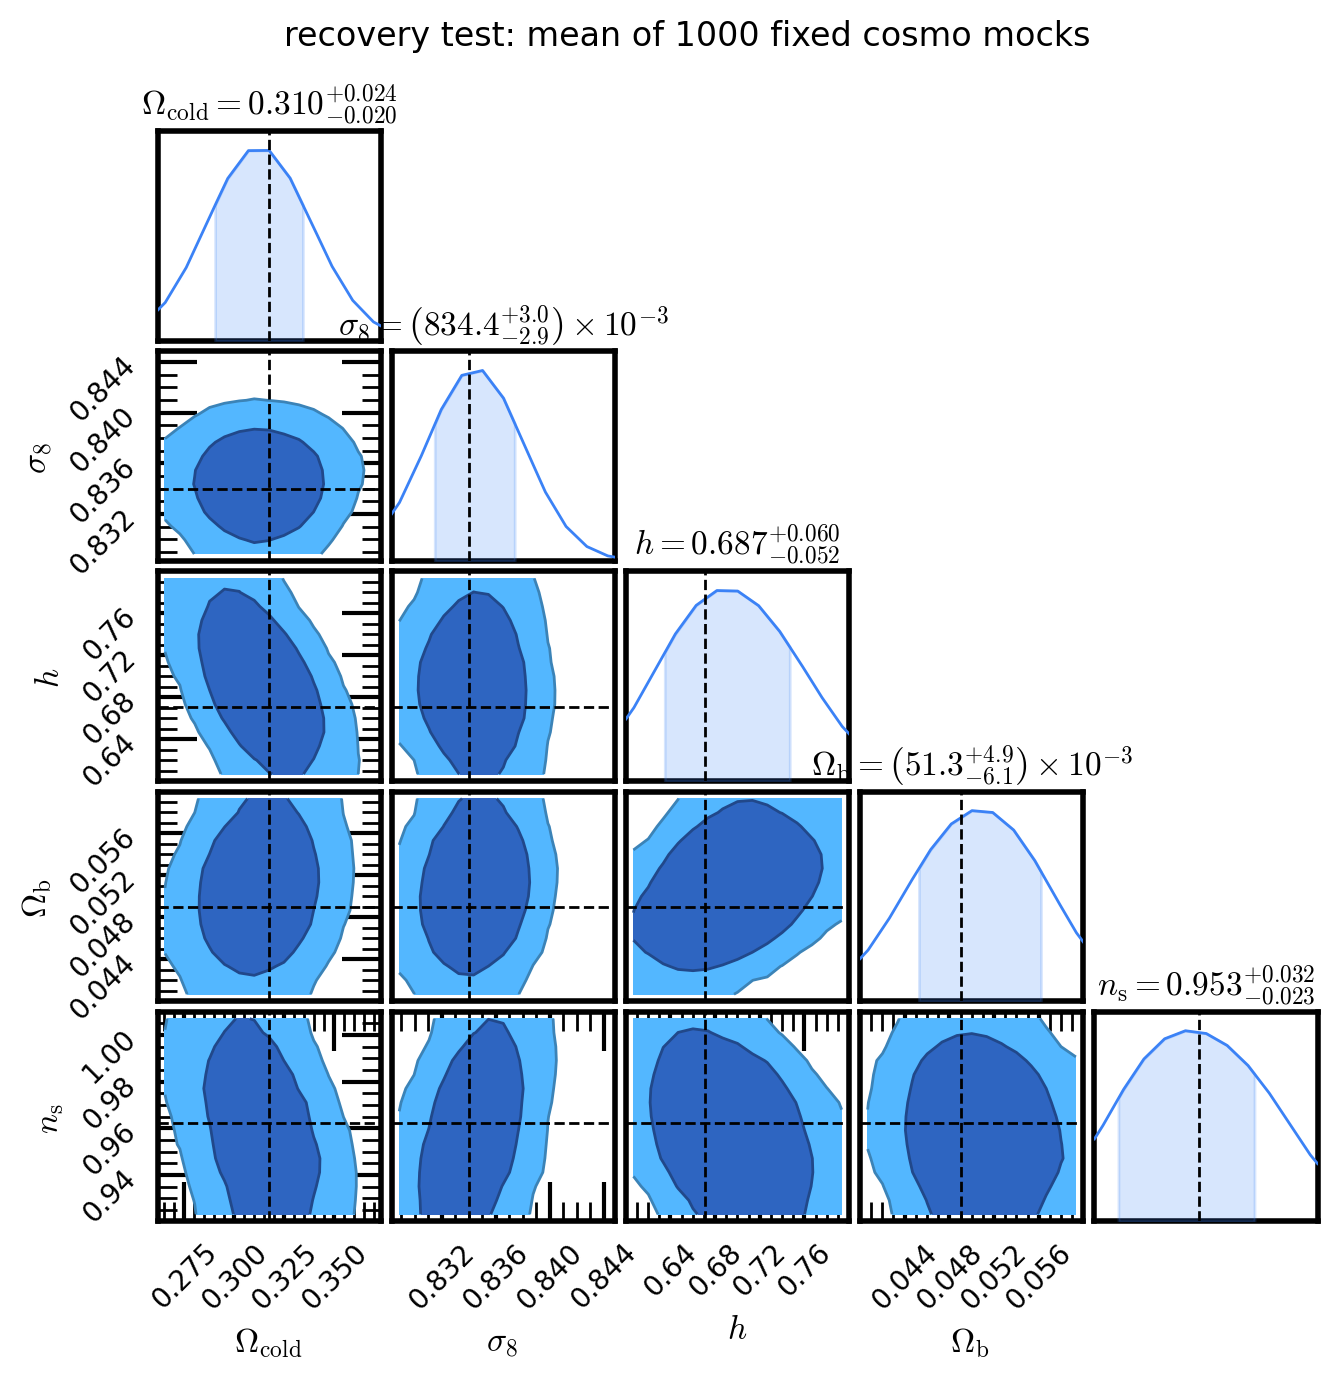

In [27]:
for idx_obs in [0]:
    theta_obs_true = theta_test[idx_obs]
    #theta_obs_true = theta_test
    print(theta_obs_true)
    print(param_names_vary)
    tags_test_mean = [f'{tag_test}_mean' for tag_test in tags_test]
    plotter.plot_contours_inf(cosmo_param_names_vary, idx_obs, theta_obs_true, 
                            inf_methods, tags_inf, tags_test=tags_test_mean,
                            colors=colors, labels_extra=labels_extra,
                            title=title)

In [28]:
param_names_show = cosmo_param_names_vary

theta_true_arr, theta_pred_arr, covs_pred_arr = [], [], []
for i, tag_inf in enumerate(tags_inf):

    _theta_test_pred, _covs_test_pred  = utils.get_moments_test_sbi(tag_inf, tag_test=tags_test[i],
                                                                     param_names=param_names_show)
    print(tag_inf)
    print(_theta_test_pred.shape)
    print(_covs_test_pred.shape)
    theta_true_arr.append(theta_test)
    theta_pred_arr.append(_theta_test_pred)
    covs_pred_arr.append(_covs_test_pred)
    
theta_true_arr = np.array(theta_true_arr)
theta_pred_arr = np.array(theta_pred_arr)
covs_pred_arr = np.array(covs_pred_arr)

(10000, 1000, 5)
_emuPk_p5_n10000_b1000_p0_n1_boxsize1000_nrlzs1_ntrain10000
(1000, 5)
(1000, 5, 5)


In [29]:
fracdiffs_arr = theta_pred_arr/theta_true_arr - 1

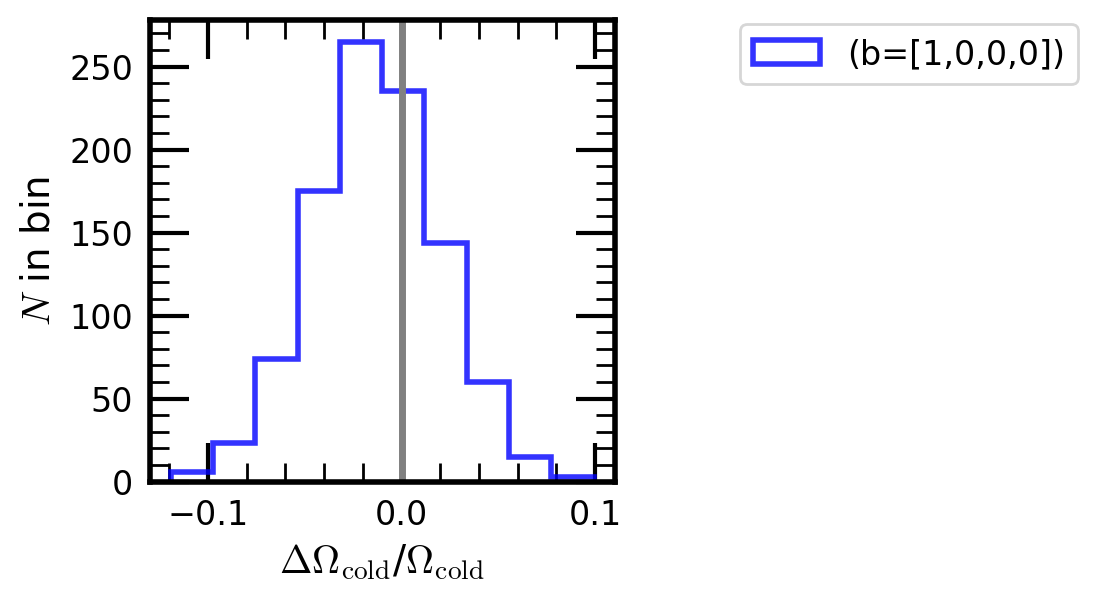

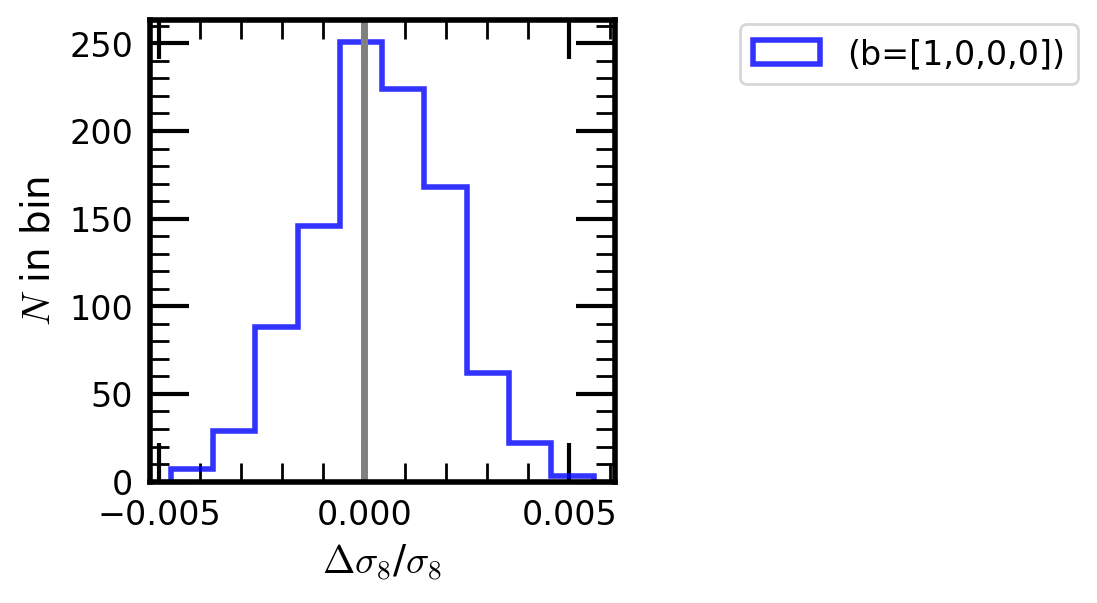

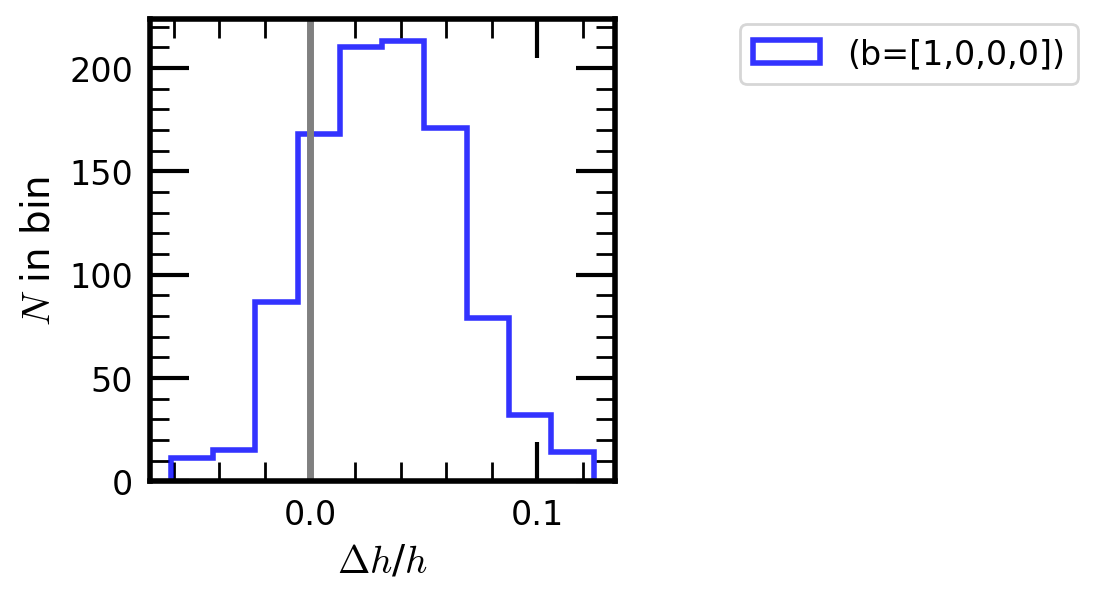

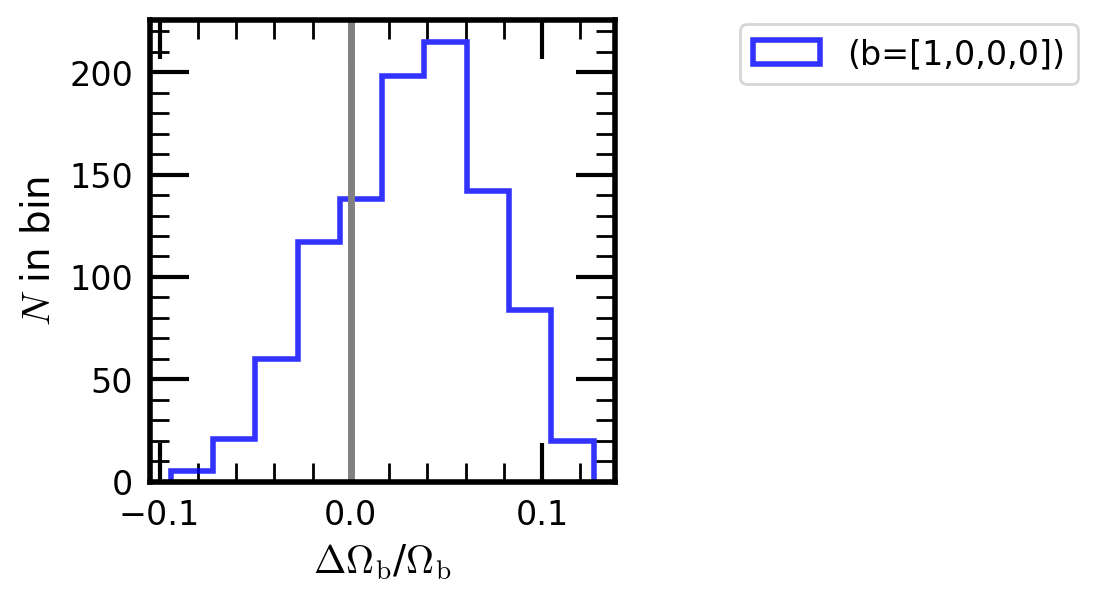

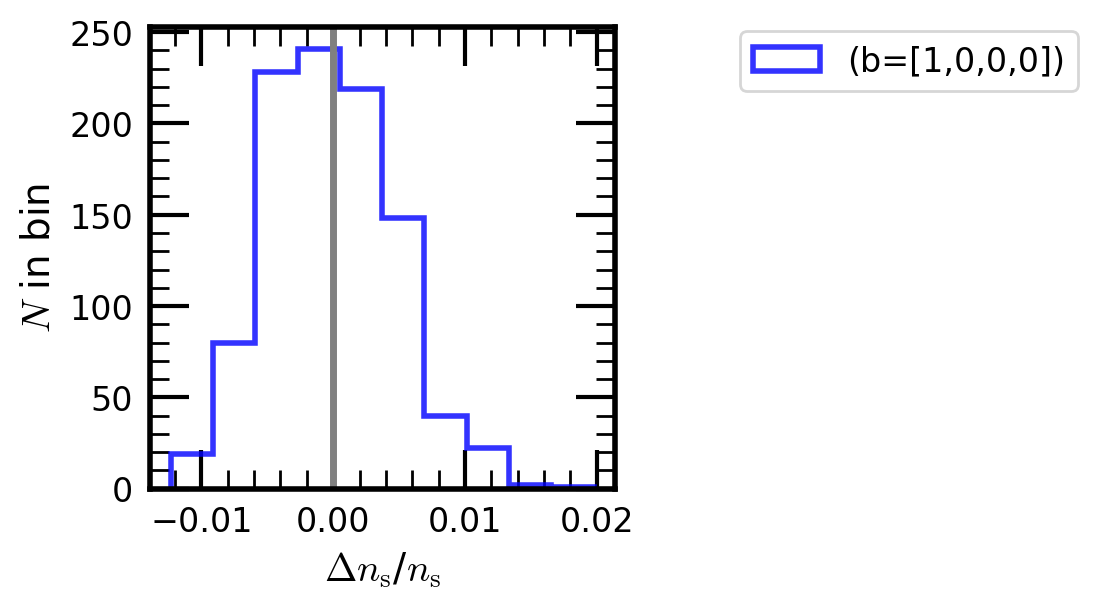

In [30]:
plotter.plot_hists_mean(fracdiffs_arr, param_labels, 
                        color_arr=colors, label_arr=labels_extra,
                        bins=10, alpha=0.8, histtype='step')

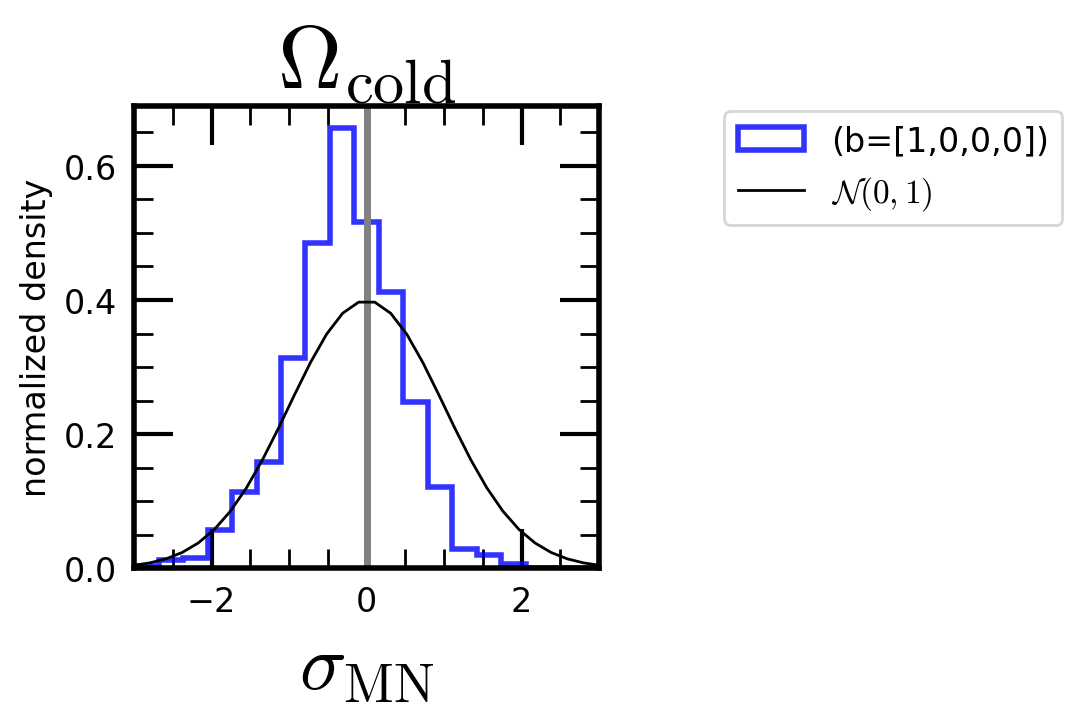

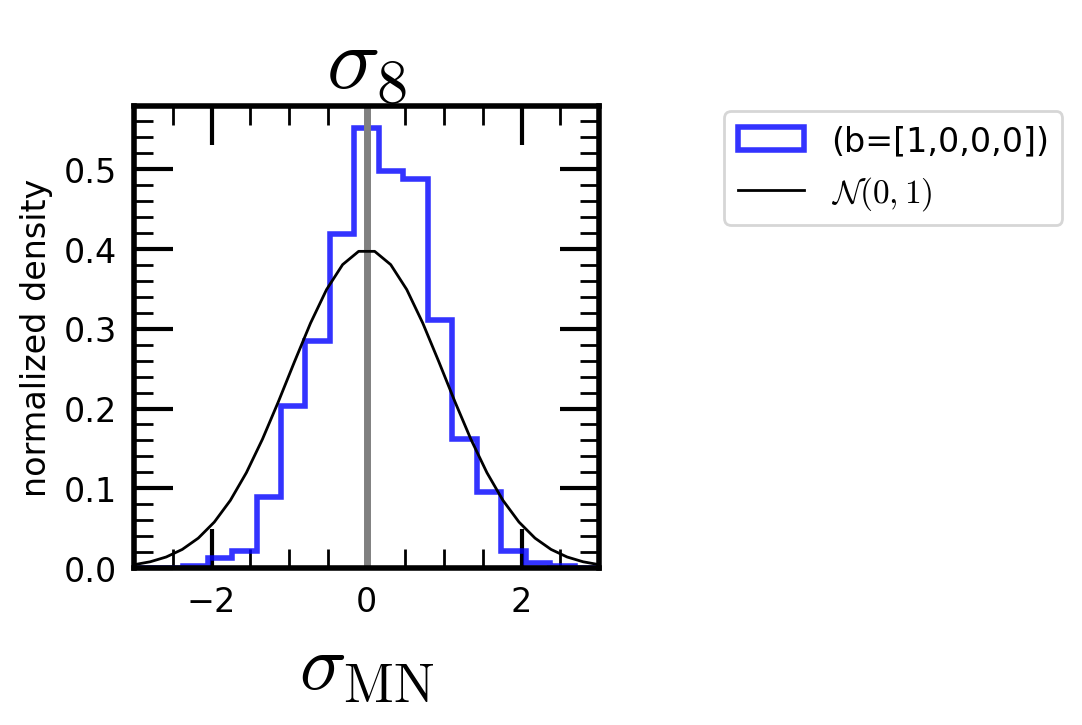

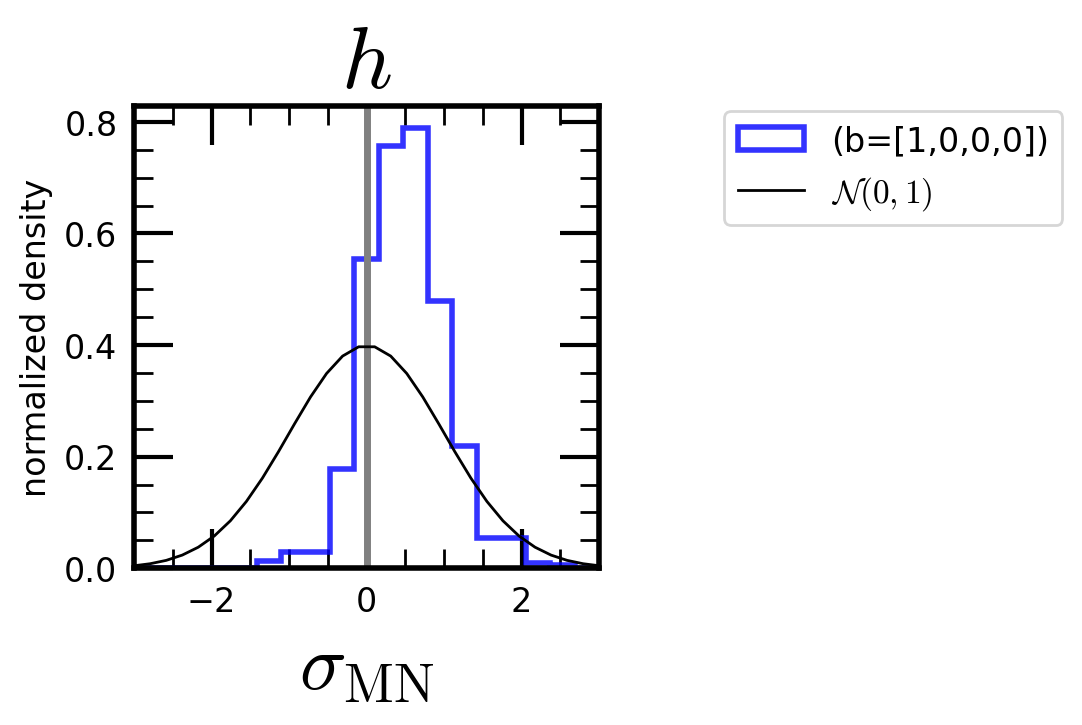

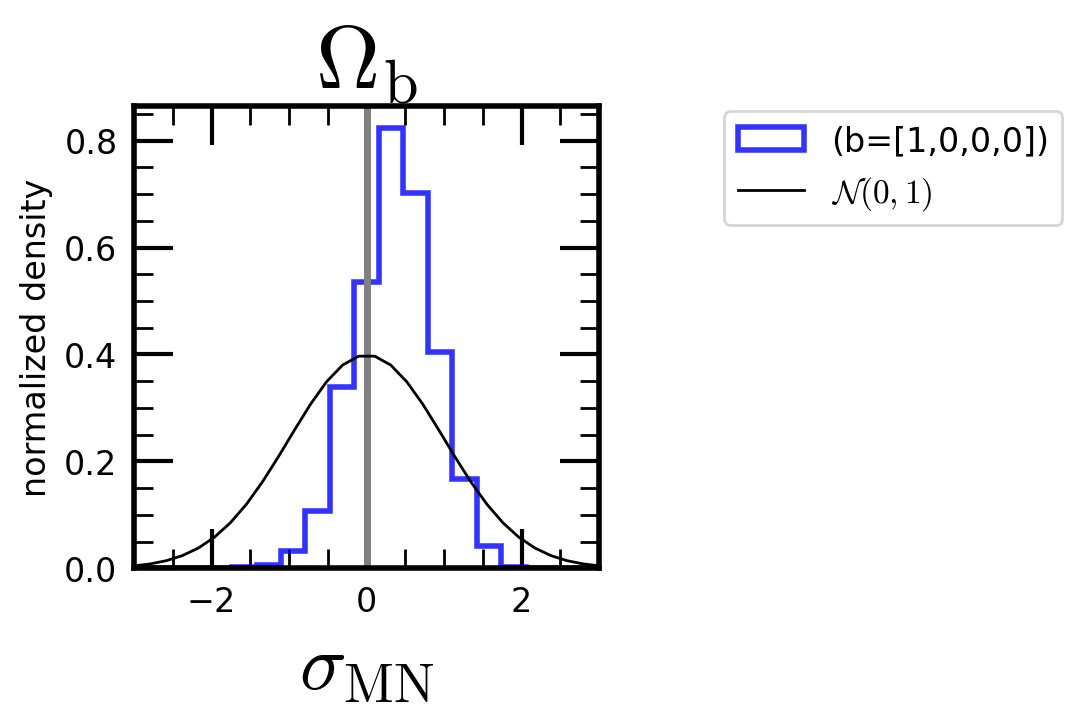

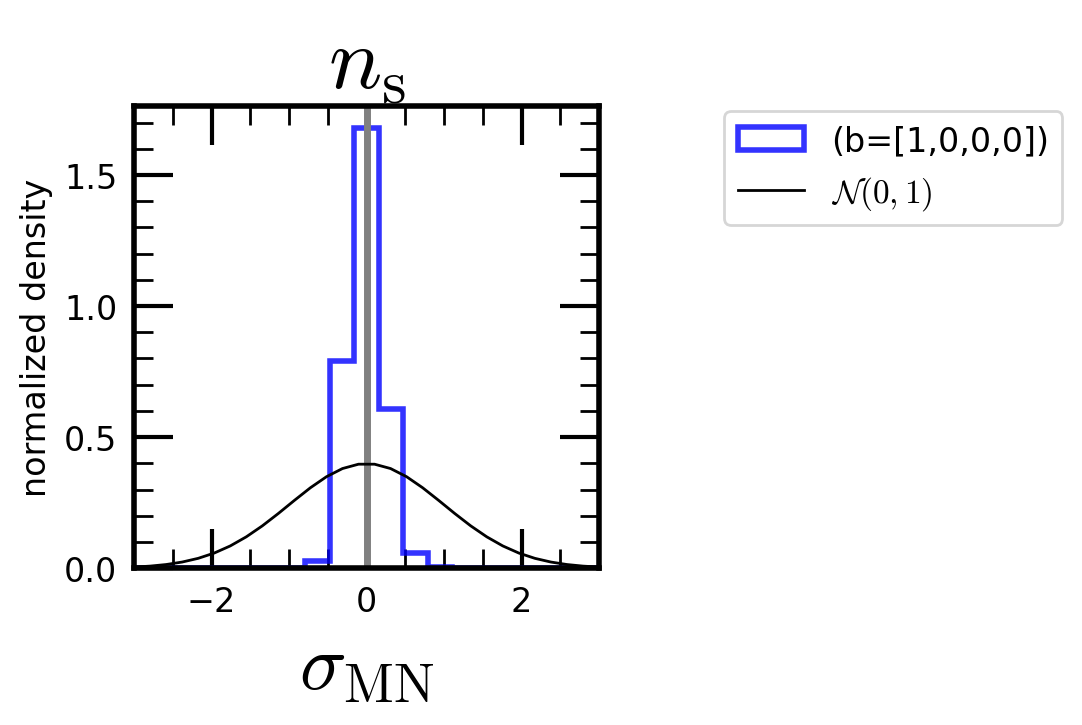

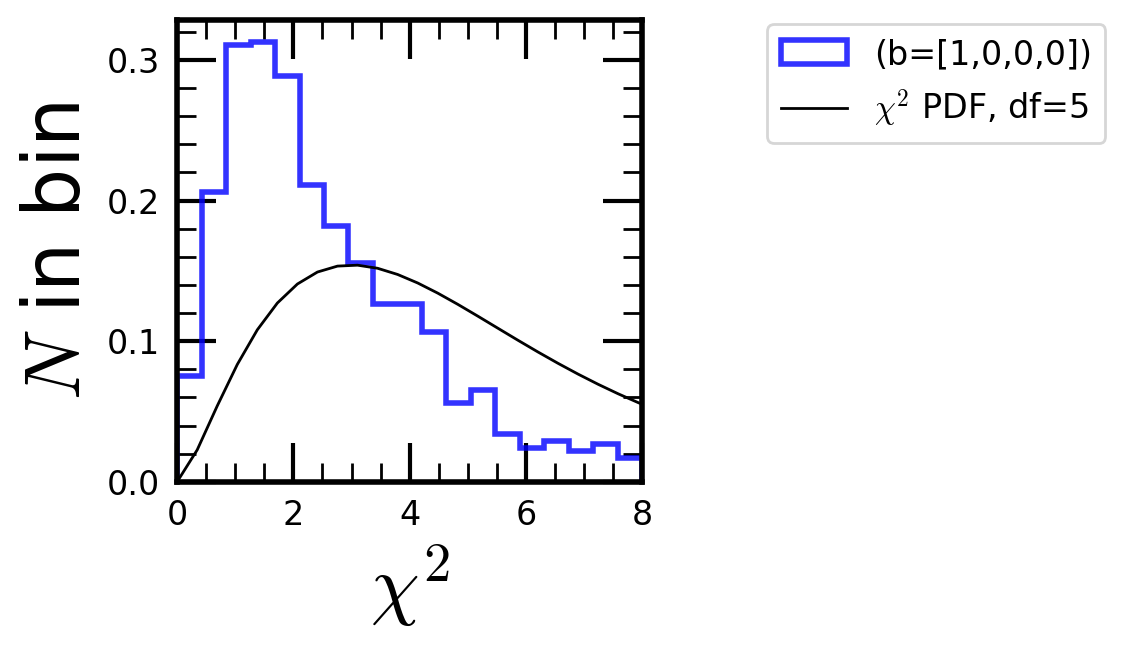

In [31]:
plotter.plot_hists_cov(theta_true_arr, theta_pred_arr, covs_pred_arr, param_labels,
                        color_arr=colors, label_arr=labels_extra,
                        #bins=10, 
                        alpha=0.8, histtype='step')